In [19]:
import os
import sys
import pandas as pd
sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())) + "/..")
if os.getcwd().endswith("Topic1"):
    os.chdir("..")
    print(f"Changed to {os.getcwd()}")
from codebase import get_total_inhabitants_and_willingness

In [21]:
within_mins = 50
punt = "hbo_wo" # ibis, hbo_wo, mbo, basis, highschool, bus, trein
mode = "ebike" # fiets, ebike
location = "Education" # Elementary Schools, High Schools, Universities, Train - NS, Train - Local

total, total_willing = get_total_inhabitants_and_willingness(punt1=punt, mode=mode, within_mins=within_mins, location=location, verbose=True)

Loaded file from Excel and saved to CSV
Demographics and filtered dataframes do not match in length: 7908 vs 7909, ignoring missing values
Total inhabitants within 50 minutes of hbo_wo from buurt: 11787440 of 17811291 = 66.18% of the Netherlands
Total willingness to cycle of those: 7092978 of 11787440 = 60.17%


<Figure size 1000x1000 with 0 Axes>

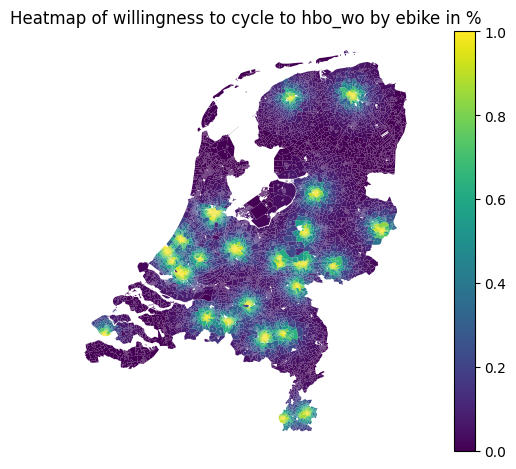

In [22]:
from codebase import plot_willingness_by_buurt_heatmap

plot_willingness_by_buurt_heatmap(punt, mode, location, savename=f"graphics/nl_maps/{punt}_by_{mode}.png")